### Trying to cluster

In [4]:
import functions

import os
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for clustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# for statistical tests
from scipy.stats import ttest_rel, ttest_ind
from statsmodels.stats.multitest import multipletests

In [45]:
import importlib
importlib.reload(functions)

<module 'functions' from '/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA4/Project Hummel/uphummel_MA4/functions.py'>

In [6]:
folder_path = "data/"
regression_info, rsfMRI_full_info = functions.load_excel_data(folder_path)

In [7]:

# Folder containing the data
folder_path = "FC_matrices_times_wp11/"

# keep only ROIS
rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 12, 54, 56, 78, 96, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]

t1_matrices, t1_subjects = functions.load_matrices(folder_path, rsfMRI_full_info, rois, type='t1_only')
all_matrices, all_subjects = functions.load_matrices(folder_path, rsfMRI_full_info, rois, type='all')
t1_t3_matched, t1_t3_subjects = functions.load_matrices(folder_path, rsfMRI_full_info, rois, type='t1_t3_matched')
t1_t4_matched, t1_t4_subjects = functions.load_matrices(folder_path, rsfMRI_full_info, rois, type='t1_t4_matched')
t1_t3_matrices, t1_t3_subjects = functions.load_matrices(folder_path, rsfMRI_full_info, rois, type='t1_t3')
t1_t4_matrices, t1_t4_subjects = functions.load_matrices(folder_path, rsfMRI_full_info, rois, type='t1_t4')
#matrices = functions.matrices_to_wide_df(matrices)
all_matrices.T1_matrix.shape

(73,)

Better to keep T1 and T3 as more subjects have these two !
From now on I'll work with matrices

In [8]:
print("matrices column names: ", t1_t3_matrices.columns)

matrices column names:  Index(['subject_id', 'T1_matrix', 'T3_matrix', 'subject_full_id',
       'Lesion_side', 'Stroke_location', 'lesion_volume_mm3', 'Gender', 'Age',
       'Education_level', 'Combined', 'Bilateral'],
      dtype='object')


##### Cluster for all matrices

Index(['Lesion_side_R', 'Lesion_side_R/L', 'Stroke_location_basal ganglia',
       'Stroke_location_cerebellum', 'Stroke_location_cortical',
       'Stroke_location_cortical (insula)',
       'Stroke_location_insula + basal ganglia', 'Stroke_location_mixed',
       'Stroke_location_pons', 'Stroke_location_pons + medulla oblongata',
       'Stroke_location_subcortical',
       'Stroke_location_subcortical (maybe basal ganglia)',
       'Stroke_location_subcortical + basal ganglia', 'Education_level_2.0',
       'Education_level_3.0', 'Education_level_4.0', 'Education_level_5.0',
       'Education_level_Unknown', 'Combined_Unknown', 'Combined_Yes',
       'Bilateral_Unknown', 'Bilateral_Yes'],
      dtype='object')


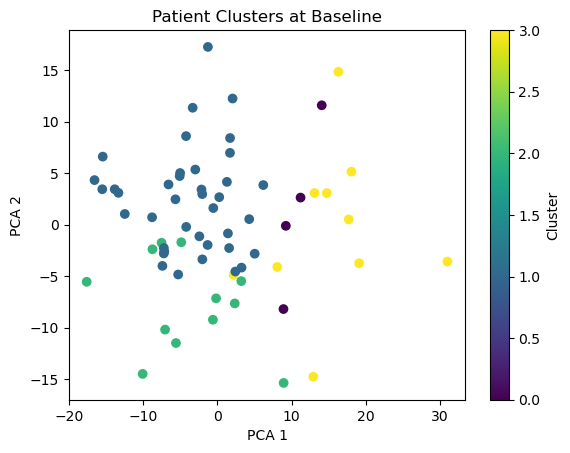

Silhouette score: 0.021924092422265305
Cluster 0: ['s063', 's015', 's082', 's021']
Cluster 1: ['s007', 's031', 's054', 's008', 's037', 's030', 's039', 's006', 's055', 's052', 's046', 's070', 's048', 's083', 's049', 's076', 's078', 's047', 's040', 's014', 's013', 's025', 's022', 's059', 's057', 's068', 's050', 's032', 's051', 's060', 's067', 's016', 's011', 's074', 's017', 's019', 's072', 's086', 's075']
Cluster 2: ['s009', 's036', 's065', 's001', 's041', 's066', 's004', 's005', 's027', 's020', 's029', 's081']
Cluster 3: ['s062', 's012', 's071', 's003', 's033', 's002', 's045', 's042', 's080', 's073']
Index(['Lesion_side_R', 'Lesion_side_R/L', 'Stroke_location_basal ganglia',
       'Stroke_location_cerebellum', 'Stroke_location_cortical',
       'Stroke_location_cortical (insula)',
       'Stroke_location_insula + basal ganglia', 'Stroke_location_mixed',
       'Stroke_location_pons', 'Stroke_location_pons + medulla oblongata',
       'Stroke_location_subcortical',
       'Stroke_locati

In [9]:
categorical_cols = ['Lesion_side', 'Stroke_location','Education_level','Combined', 'Bilateral']
numerical_cols = ['lesion_volume_mm3','Age','Gender']

all_matrices_labeled = functions.cluster_and_plot(all_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4, plot=True)
t1_t3_matrices_labeled = functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4, plot=False)
t1_t4_matrices_labeled = functions.cluster_and_plot(t1_t4_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4, plot=False)

# NORMAL THAT WE GET THE SAME CLUSTERS FOR ALL TIMEPOINTS
# because we are using the same data for clustering (T1)

#### Version Chat payant:

Flattening FC matrices on 65 subjects...
[INFO] Missing numerical values detected. Imputing with column means...
Applying PCA...
Testing different cluster numbers...


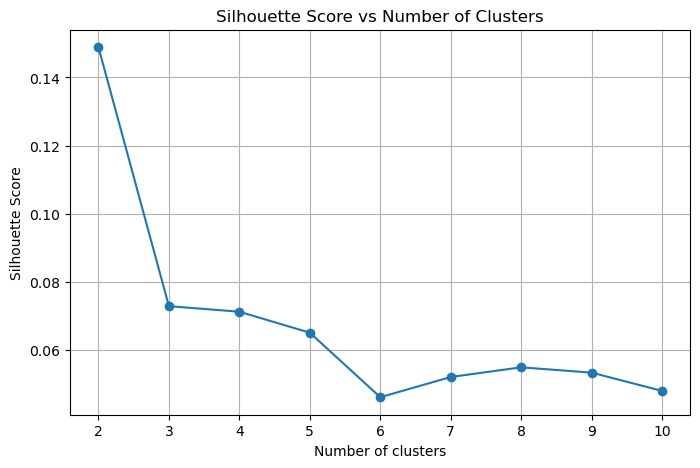

Best number of clusters according to silhouette score: 2


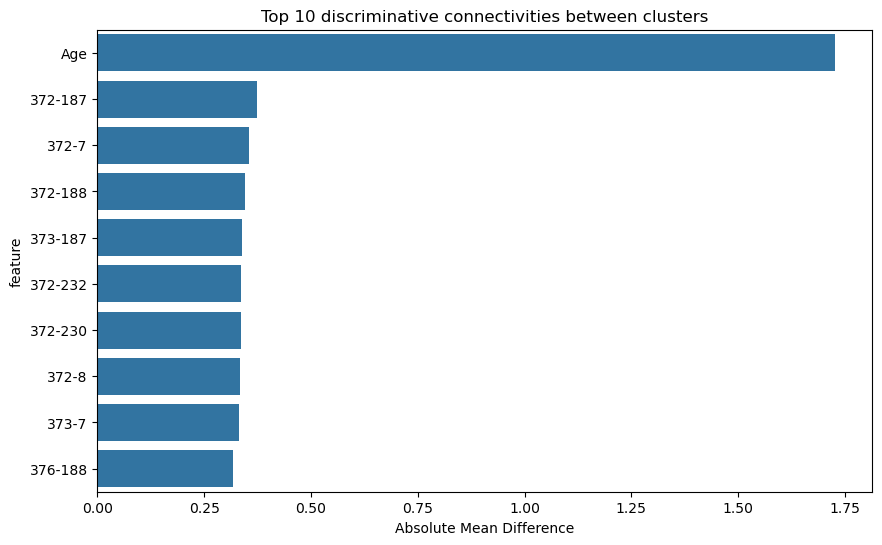

In [10]:
selected_rois_labels = [362, 363, 364, 367, 371, 372, 373, 376] 

t1_t3_matrices_labeled, clusters, silhouette_scores, pca_features, scaler, pca, all_features, feature_names = functions.cluster_subjects(
    t1_t3_matrices, 
    selected_rois_labels, 
    matrix_column='T1_matrix', 
    numerical_cols=numerical_cols, 
    categorical_cols=categorical_cols
)

importance_df = functions.compute_feature_importance(all_features, clusters, feature_names)

Flattening FC matrices on 65 subjects...
[INFO] Missing numerical values detected. Imputing with column means...
Applying PCA...
Testing different cluster numbers...


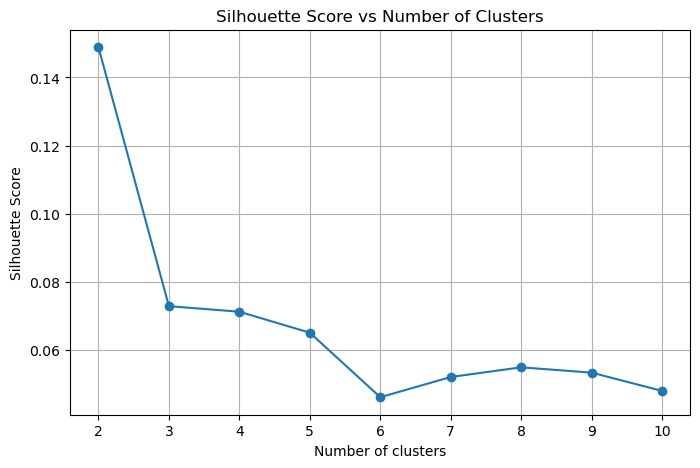

Best number of clusters according to silhouette score: 2


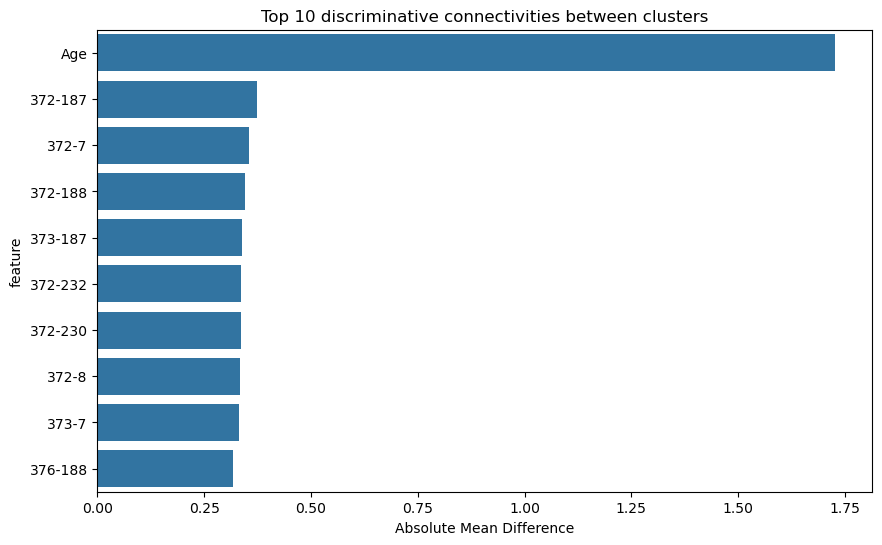

In [11]:
t1_t4_matrices_labeled, clusters, silhouette_scores, pca_features, scaler, pca, all_features, feature_names = functions.cluster_subjects(
    t1_t4_matrices, 
    selected_rois_labels, 
    matrix_column='T1_matrix', 
    numerical_cols=numerical_cols, 
    categorical_cols=categorical_cols
)

importance_df = functions.compute_feature_importance(all_features, clusters, feature_names)

### Beginning of statistical testing


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (13, 33, 33)
Cluster 0 - Shape of T3 matrices: (13, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 36.86it/s]


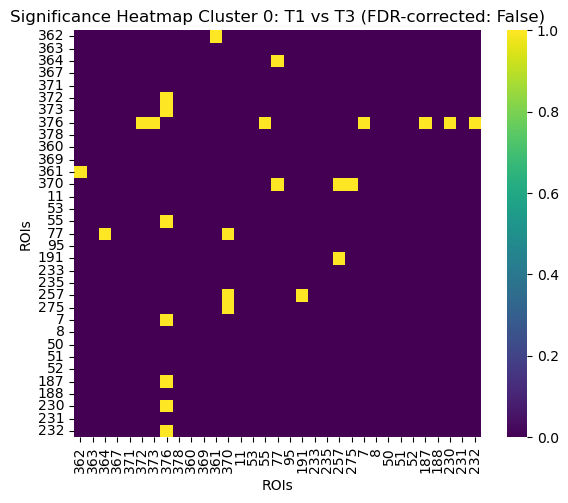


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (26, 33, 33)
Cluster 1 - Shape of T3 matrices: (26, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:01<00:00, 31.97it/s]


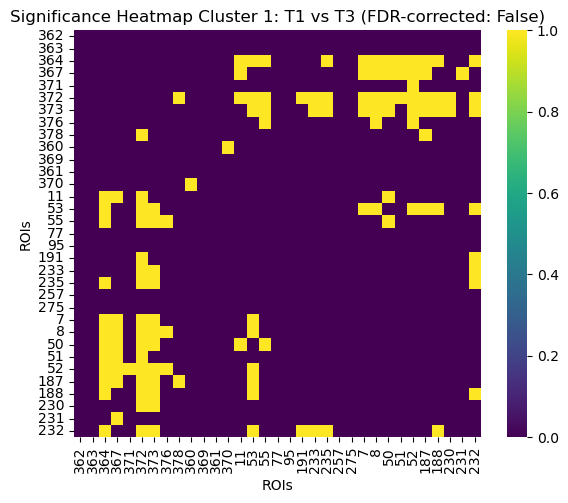

In [12]:
results = functions.get_sig_matrix(t1_t3_matrices_labeled, rois, correction=False, alpha=0.05, cluster=True)


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (13, 33, 33)
Cluster 0 - Shape of T3 matrices: (13, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:01<00:00, 32.97it/s]


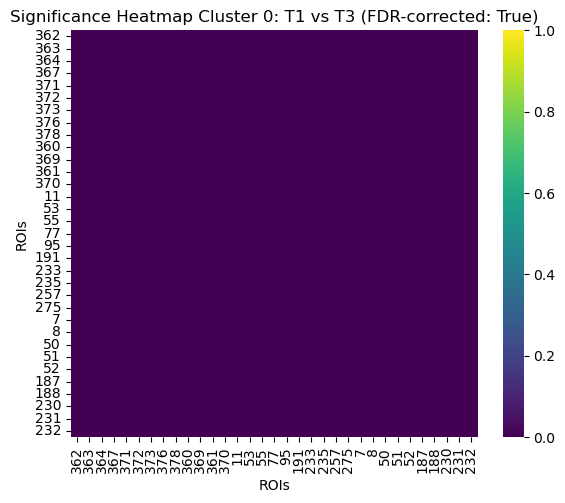


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (26, 33, 33)
Cluster 1 - Shape of T3 matrices: (26, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 35.54it/s]


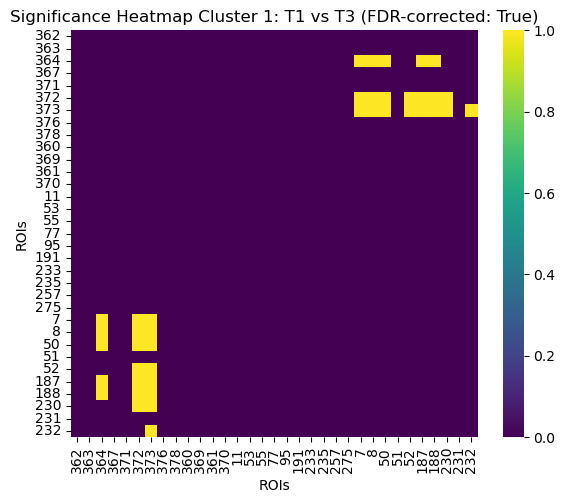

In [13]:
results = functions.get_sig_matrix(t1_t3_matrices_labeled, rois, correction=True, alpha=0.05, cluster=True)


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (12, 33, 33)
Cluster 0 - Shape of T4 matrices: (12, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 33.46it/s]


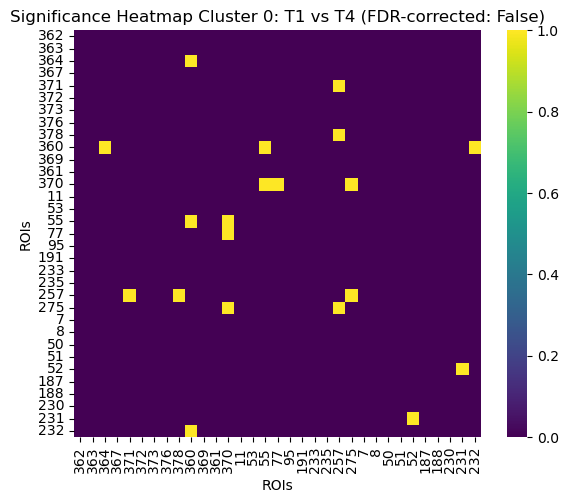


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (24, 33, 33)
Cluster 1 - Shape of T4 matrices: (24, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 34.54it/s]


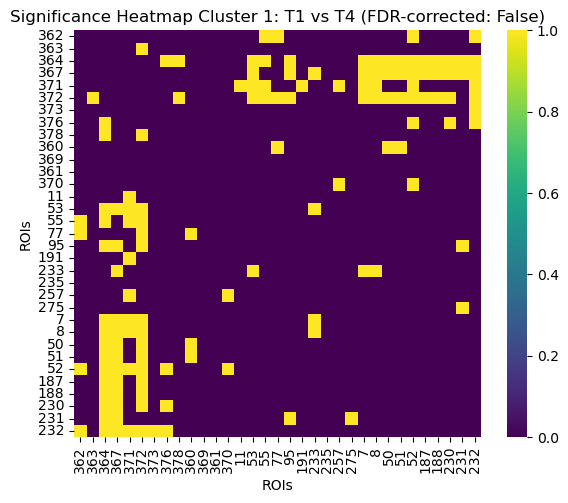

In [14]:
results = functions.get_sig_matrix(t1_t4_matrices_labeled, rois, tp=4, correction=False, alpha=0.05, cluster=True)

Shape of T1 matrices: (65, 33, 33)
Shape of T3 matrices: (44, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 34.35it/s]


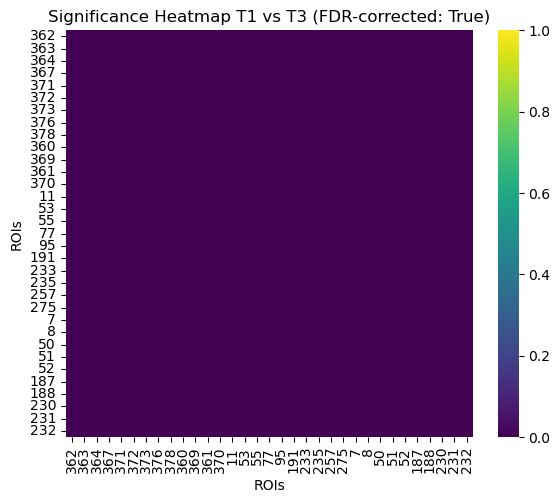

Shape of T1 matrices: (65, 33, 33)
Shape of T3 matrices: (44, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 34.43it/s]


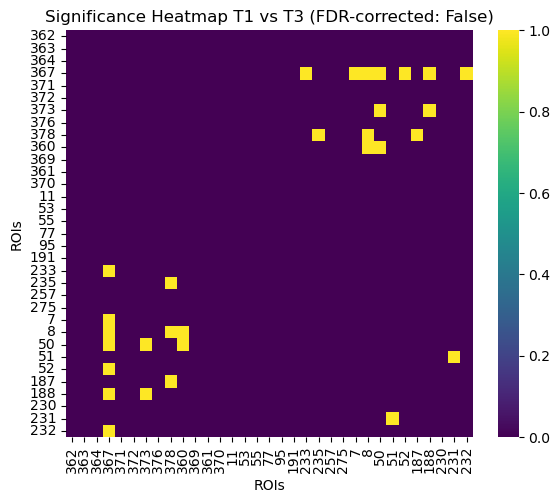


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (12, 33, 33)
Cluster 0 - Shape of T4 matrices: (12, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 35.47it/s]


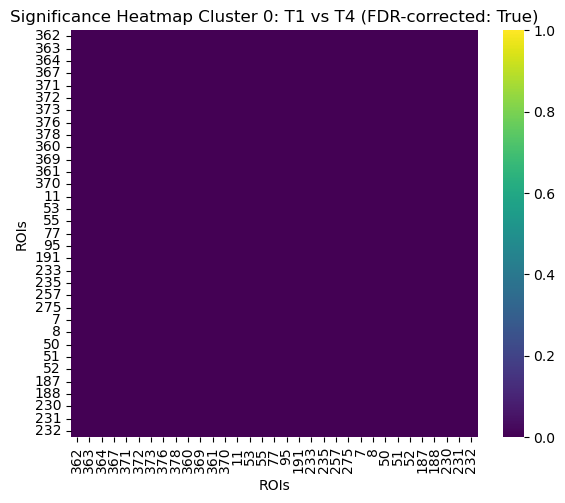


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (24, 33, 33)
Cluster 1 - Shape of T4 matrices: (24, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 35.22it/s]


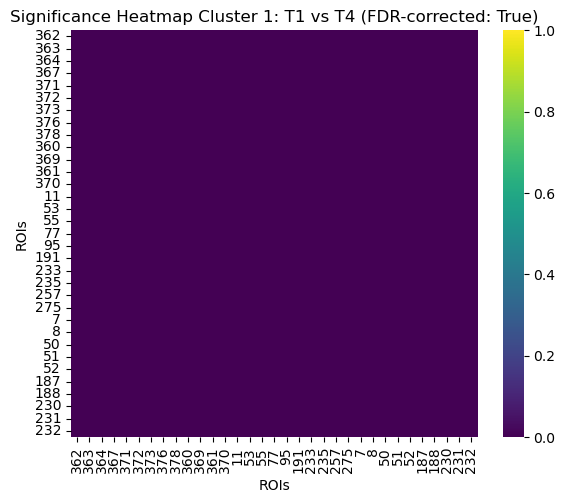


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (12, 33, 33)
Cluster 0 - Shape of T4 matrices: (12, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 37.23it/s]


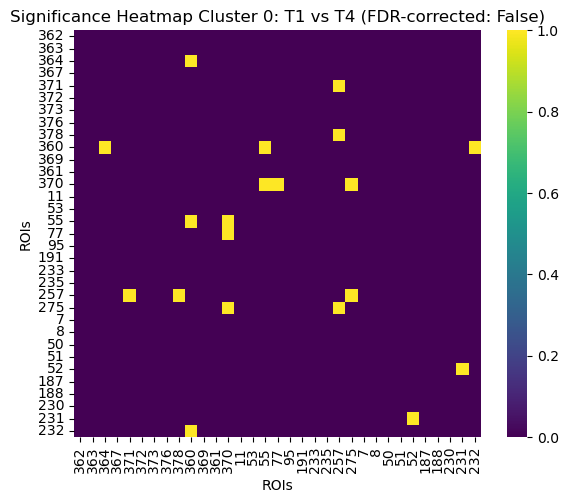


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (24, 33, 33)
Cluster 1 - Shape of T4 matrices: (24, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 36.31it/s]


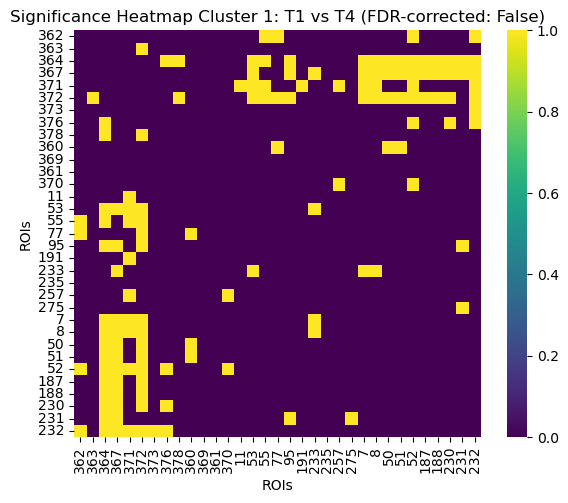

Shape of T1 matrices: (65, 33, 33)
Shape of T4 matrices: (42, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 37.19it/s]


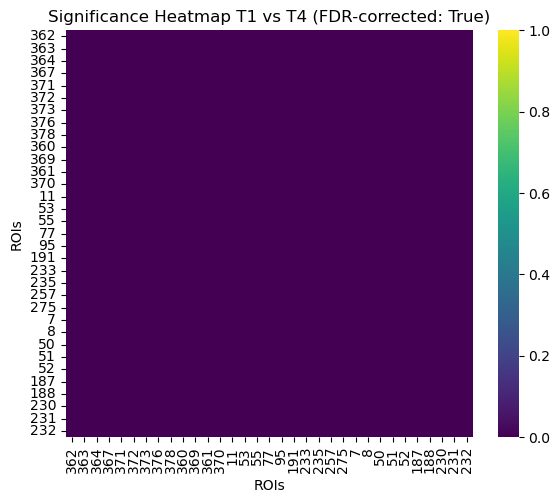

Shape of T1 matrices: (65, 33, 33)
Shape of T4 matrices: (42, 33, 33)


  0%|          | 0/33 [00:00<?, ?it/s]/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 33/33 [00:00<00:00, 35.63it/s]


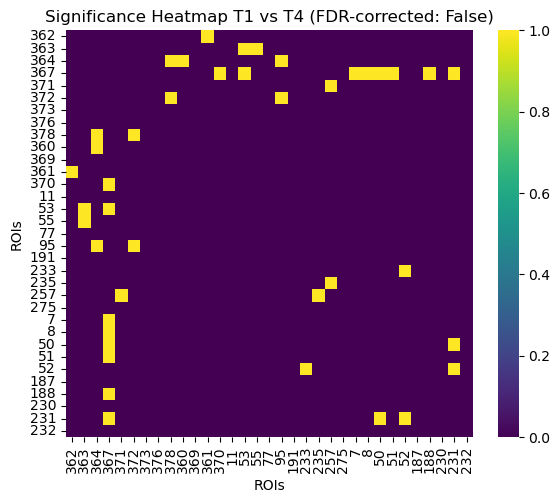

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[       nan, 0.25551029, 0.4015783 , ..., 0.64122593, 0.62244395,
         0.34159699],
        [0.25551029,        nan, 0.52060866, ..., 0.34481731, 0.26292186,
         0.87332444],
        [0.4015783 , 0.52060866,        nan, ..., 0.16426855, 0.37499409,
         0.09500018],
        ...,
        [0.64122593, 0.34481731, 0.16426855, ...,        nan, 0.55472845,
         0.6415112 ],
        [0.62244395, 0.26292186, 0.37499409, ..., 0.55472845,        nan,
         0.50564467],
        [0.34159699, 0.87332444, 0.09500018, ..., 0.6415112 , 0.50564467,
                nan]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [Fal

In [15]:
functions.get_sig_matrix(t1_t3_matrices, rois, tp=3, correction=True, alpha=0.05, cluster=False)
functions.get_sig_matrix(t1_t3_matrices, rois, tp=3, correction=False, alpha=0.05, cluster=False)
functions.get_sig_matrix(t1_t4_matrices_labeled, rois, tp=4, correction=True, alpha=0.05, cluster=True)
functions.get_sig_matrix(t1_t4_matrices_labeled, rois, tp=4, correction=False, alpha=0.05, cluster=True)
functions.get_sig_matrix(t1_t4_matrices, rois, tp=4, correction=True, alpha=0.05, cluster=False)
functions.get_sig_matrix(t1_t4_matrices, rois, tp=4, correction=False, alpha=0.05, cluster=False)

### Look at difference between FC

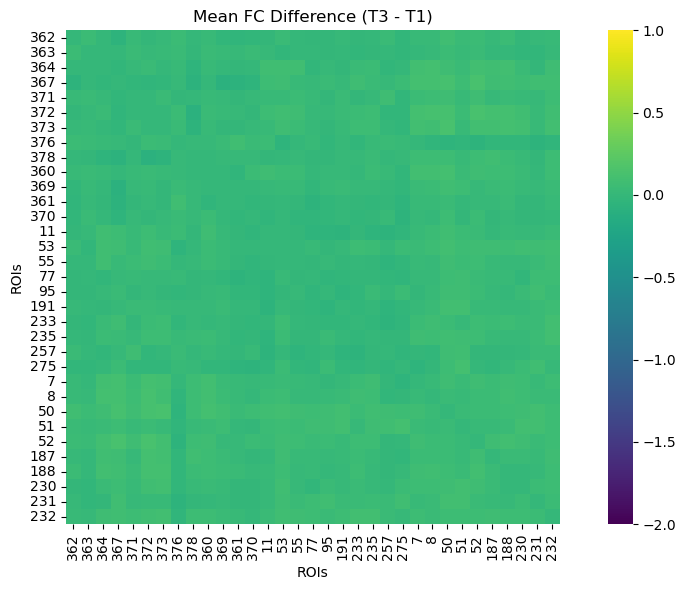

In [16]:
t1_t3_matched_diff = functions.compute_FC_diff(t1_t3_matched, rois, tp = 3)

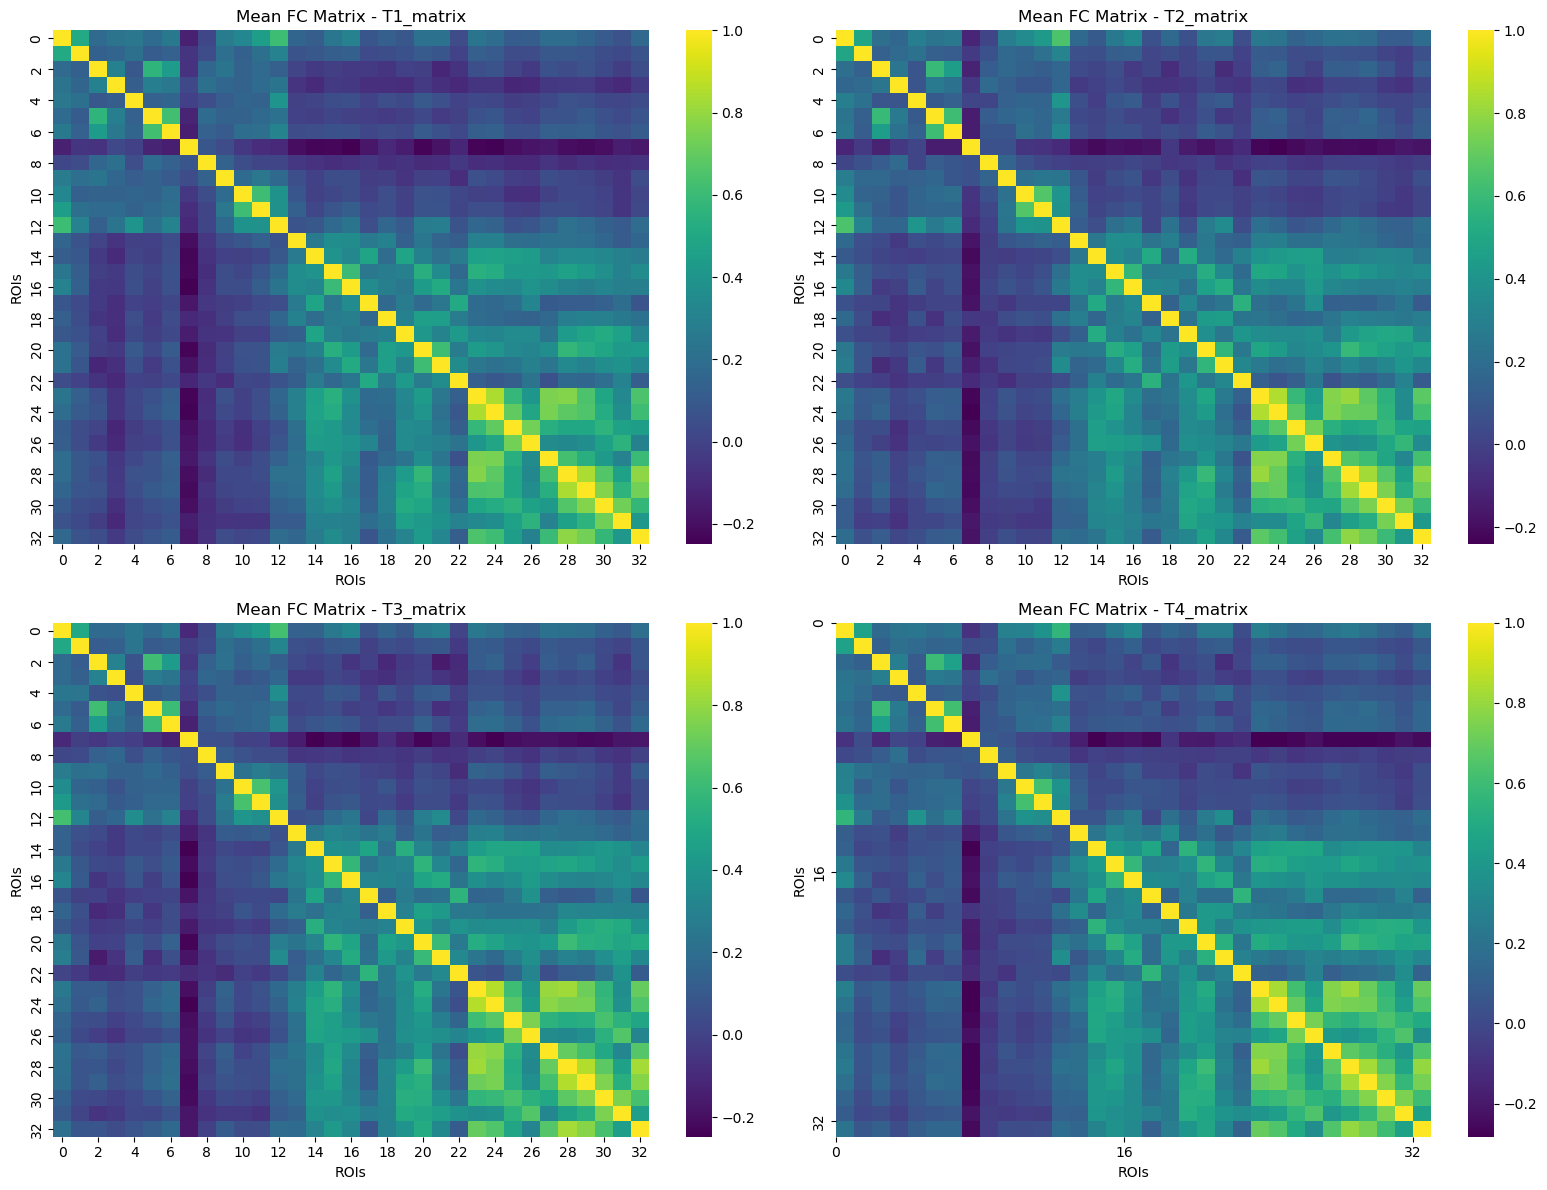

In [17]:
functions.plot_mean_FC_matrices(all_matrices, rois)

### Regression Analysis

In [18]:
functions.test_normality(regression_info)

                               Variable         W       p-value  \
0                     lesion_volume_mm3  0.662422  1.387019e-25   
1                                 NIHSS  0.599826  1.894083e-27   
2                       FAB_abstraction  0.330186  1.608263e-33   
3                       FAB_flexibility  0.765989  8.369961e-22   
4                     FAB_programmation  0.526658  2.335800e-29   
5       FAB_sensitivity_to_interference  0.379692  1.418530e-32   
6                FAB_inhibitory_control  0.583891  6.911108e-28   
7            FAB_environmental_autonomy  0.122960  5.953099e-37   
8                               FAB_TOT  0.777710  2.673758e-21   
9                     Stroop_color_time  0.485765  2.520191e-30   
10                   Stroop_color_error  0.269896  1.343274e-34   
11                    Stroop_words_time  0.591968  1.147657e-27   
12                   Stroop_words_error  0.280795  2.077752e-34   
13             Stroop_interference_time  0.767888  1.007287e-2

,Variable,W,p-value,Normal? (p > 0.05)
0,lesion_volume_mm3,0.662422,1.387019e-25,False
1,NIHSS,0.599826,1.894083e-27,False
2,FAB_abstraction,0.330186,1.608263e-33,False
3,FAB_flexibility,0.765989,8.369961e-22,False
4,FAB_programmation,0.526658,2.335800e-29,False
5,FAB_sensitivity_to_interference,0.379692,1.418530e-32,False
6,FAB_inhibitory_control,0.583891,6.911108e-28,False
7,FAB_environmental_autonomy,0.122960,5.953099e-37,False
8,FAB_TOT,0.777710,2.673758e-21,False
9,Stroop_color_time,0.485765,2.520191e-30,False


only SMN_intra_unaff_FC is normal !

now I will look at wilcoxon score for different timepoints

In [19]:
results = functions.motor_longitudinal(regression_info)
results

,Task,n,p-value,Statistically sig. change between TP
0,FAB_abstraction,47,8.510499e-01,No
1,FAB_flexibility,47,4.677735e-03,Yes
2,FAB_programmation,47,1.322356e-02,Yes
3,FAB_sensitivity_to_interference,47,4.673636e-03,Yes
4,FAB_inhibitory_control,47,2.177073e-03,Yes
5,FAB_environmental_autonomy,47,8.326452e-02,No
6,FAB_TOT,47,5.472044e-05,Yes
7,Stroop_color_time,47,3.593277e-02,Yes
8,Stroop_color_error,47,2.905775e-01,No
9,Stroop_words_time,47,4.887531e-02,Yes


In [20]:
# Split subjects based on "Lesion_side"
lesion_left = regression_info[regression_info['Lesion_side'] == 'L']
lesion_right = regression_info[regression_info['Lesion_side'] == 'R']
lesion_both = regression_info[regression_info['Lesion_side'] == 'R/L']
lesion_unknown = regression_info[~regression_info['Lesion_side'].isin(['L', 'R', 'R/L'])]

# Print the number of subjects in each group
print(f"Left Lesion: {len(lesion_left)} subjects")
print(f"Right Lesion: {len(lesion_right)} subjects")
print(f"Bilateral Lesion: {len(lesion_both)} subjects")
print(f"Unknown Lesion: {len(lesion_unknown)} subjects")

Left Lesion: 148 subjects
Right Lesion: 184 subjects
Bilateral Lesion: 8 subjects
Unknown Lesion: 4 subjects


In [21]:
from scipy.stats import wilcoxon

start_col='FAB_abstraction'
end_col='nmf_motor'
cols_to_keep = ['subject_full_id','TimePoint','Lesion_side'] + regression_info.loc[:, start_col:end_col].columns.tolist()

regression_info_part = regression_info[cols_to_keep]
lesion_left = regression_info_part[regression_info_part['Lesion_side'] == 'L']
lesion_right = regression_info_part[regression_info_part['Lesion_side'] == 'R']
lesion_both = regression_info_part[regression_info_part['Lesion_side'] == 'R/L']
lesion_unknown = regression_info_part[~regression_info_part['Lesion_side'].isin(['L', 'R', 'R/L'])]

score_T1_L = lesion_left[lesion_left.TimePoint == "T1"].copy().dropna()
score_T_L = lesion_left[lesion_left.TimePoint == f"T3"].copy().dropna()

score_T1_R = lesion_right[lesion_right.TimePoint == "T1"].copy().dropna()
score_T_R = lesion_right[lesion_right.TimePoint == f"T3"].copy().dropna()

# Match score_T1 and score_T3 based on 'subject_full_id'
common_ids = set(score_T1_L['subject_full_id']).intersection(score_T_L['subject_full_id'])
score_T1_L_matched = score_T1_L[score_T1_L['subject_full_id'].isin(common_ids)].set_index('subject_full_id').drop(columns=['TimePoint','Lesion_side'])
score_T_L_matched = score_T_L[score_T_L['subject_full_id'].isin(common_ids)].set_index('subject_full_id').drop(columns=['TimePoint','Lesion_side'])
common_ids = set(score_T1_R['subject_full_id']).intersection(score_T_R['subject_full_id'])
score_T1_R_matched = score_T1_R[score_T1_R['subject_full_id'].isin(common_ids)].set_index('subject_full_id').drop(columns=['TimePoint','Lesion_side'])
score_T_R_matched = score_T_R[score_T_R['subject_full_id'].isin(common_ids)].set_index('subject_full_id').drop(columns=['TimePoint','Lesion_side'])


# Run Wilcoxon test across columns (axis=0)
stat_L, p_L = wilcoxon(score_T1_L_matched, score_T_L_matched, axis=0)
stat_R, p_R = wilcoxon(score_T1_R_matched, score_T_R_matched, axis=0)

results_L = []
results_R = []
for col in score_T1_L_matched.columns:
    try:
        stat, pval = wilcoxon(score_T1_L_matched[col], score_T_L_matched[col])
        results_L.append({
            'Task': col, 
            'n': len(score_T1_L_matched), 
            'p-value': pval, 
            'Statistically sig. change between TP': 'Yes' if pval < 0.05 else 'No'
        })
    except ValueError:
        results_L.append({
            'Task': col, 
            'n': len(score_T1_L_matched), 
            'p-value': None, 
            'Statistically sig. change between TP': 'No'
        })
for col in score_T1_R_matched.columns:
    try:
        stat, pval = wilcoxon(score_T1_R_matched[col], score_T_R_matched[col])
        results_R.append({
            'Task': col, 
            'n': len(score_T1_R_matched), 
            'p-value': pval, 
            'Statistically sig. change between TP': 'Yes' if pval < 0.05 else 'No'
        })
    except ValueError:
        results_R.append({
            'Task': col, 
            'n': len(score_T1_R_matched), 
            'p-value': None, 
            'Statistically sig. change between TP': 'No'
        })
results_L_df = pd.DataFrame(results_L)
results_R_df = pd.DataFrame(results_R)

/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_wilcoxon.py:182: RuntimeWarning: invalid value encountered in divide
  z = (r_plus - mn) / se


In [22]:
# GOOD !!!!

yeo_path = "data/hcp_mmp10_yeo7_modes_indices.csv"
yeo = pd.read_csv(yeo_path, names=['Yeo_Network'])
yeo['Glasser_Index'] = range(1, 361)
new_rows = pd.DataFrame({
    'Glasser_Index': range(361, 380),      # 360 to 379 inclusive
    'Yeo_Network': 8               # constant value 8
})

region_to_yeo = pd.concat([yeo, new_rows], ignore_index=True)
region_to_yeo.Yeo_Network = region_to_yeo.Yeo_Network - 1
region_to_yeo.Glasser_Index = region_to_yeo.Glasser_Index - 1
region_to_yeo

,Yeo_Network,Glasser_Index
0,0,0
1,2,1
2,0,2
3,0,3
4,0,4
...,...,...
374,7,374
375,7,375
376,7,376
377,7,377


In [23]:
network_to_indices = region_to_yeo.groupby('Yeo_Network')['Glasser_Index'].apply(list).to_dict()
#full_rois = np.arange(1, 379)
t1_matrix = t1_matrices.T1_matrix[1] # not none matrix to test

In [24]:
print("Yeo network keys:", list(network_to_indices.keys()))
print("glasser keys:", list(network_to_indices.values()))

Yeo network keys: [0, 1, 2, 3, 4, 5, 6, 7]
glasser keys: [[0, 2, 3, 4, 5, 6, 12, 15, 17, 18, 19, 20, 21, 22, 118, 120, 125, 126, 141, 145, 151, 152, 153, 154, 155, 157, 158, 159, 162, 180, 181, 182, 183, 184, 185, 186, 192, 195, 196, 197, 198, 199, 200, 201, 202, 298, 300, 305, 306, 321, 331, 332, 333, 334, 335, 337, 338, 339, 342], [7, 8, 23, 35, 38, 39, 40, 50, 51, 52, 53, 54, 55, 99, 100, 101, 102, 103, 106, 123, 124, 138, 167, 172, 173, 174, 187, 188, 203, 215, 218, 219, 220, 230, 231, 232, 233, 234, 235, 278, 279, 280, 281, 282, 283, 286, 294, 303, 304, 347, 352, 353, 354], [1, 9, 10, 16, 41, 44, 45, 46, 47, 48, 49, 94, 95, 115, 116, 135, 136, 137, 140, 142, 156, 189, 190, 206, 221, 224, 225, 226, 227, 228, 229, 259, 274, 275, 295, 296, 315, 316, 317, 319, 320, 322, 325, 336], [24, 36, 37, 42, 43, 56, 58, 59, 77, 98, 104, 105, 107, 108, 112, 113, 114, 139, 146, 147, 166, 168, 177, 191, 204, 207, 216, 217, 222, 223, 236, 237, 238, 239, 257, 284, 285, 287, 288, 291, 292, 293, 318, 3

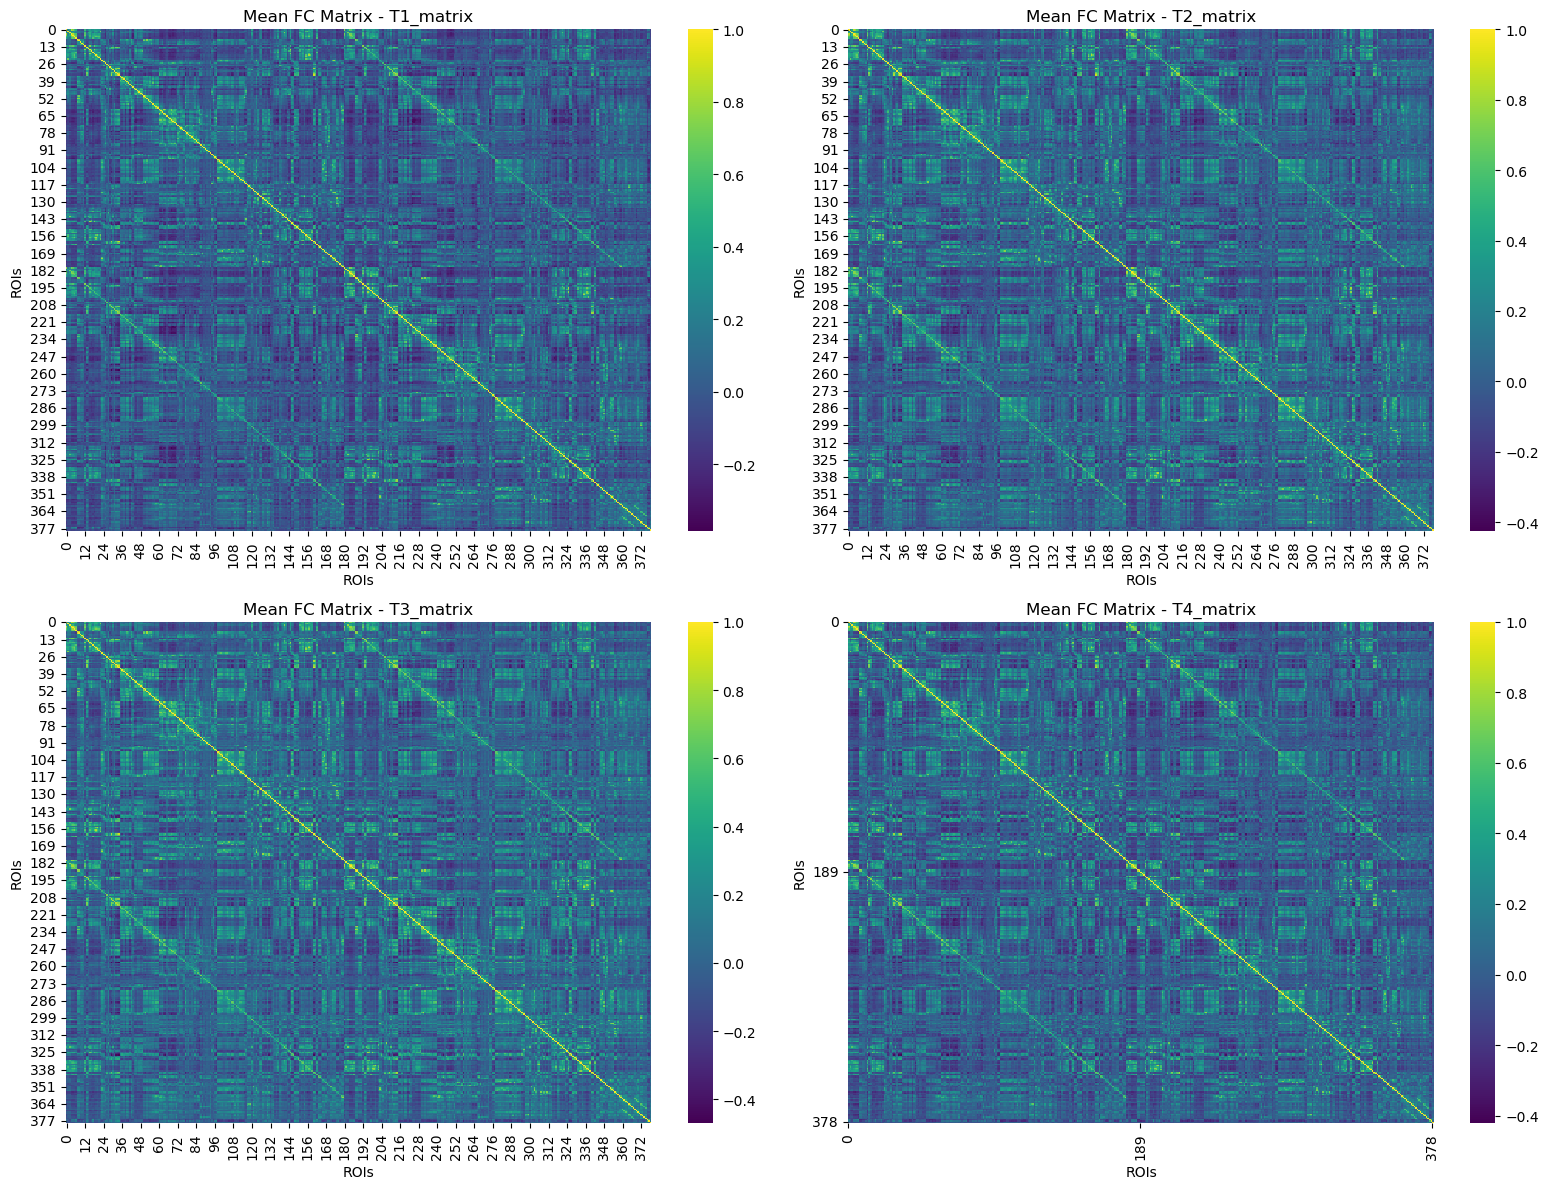

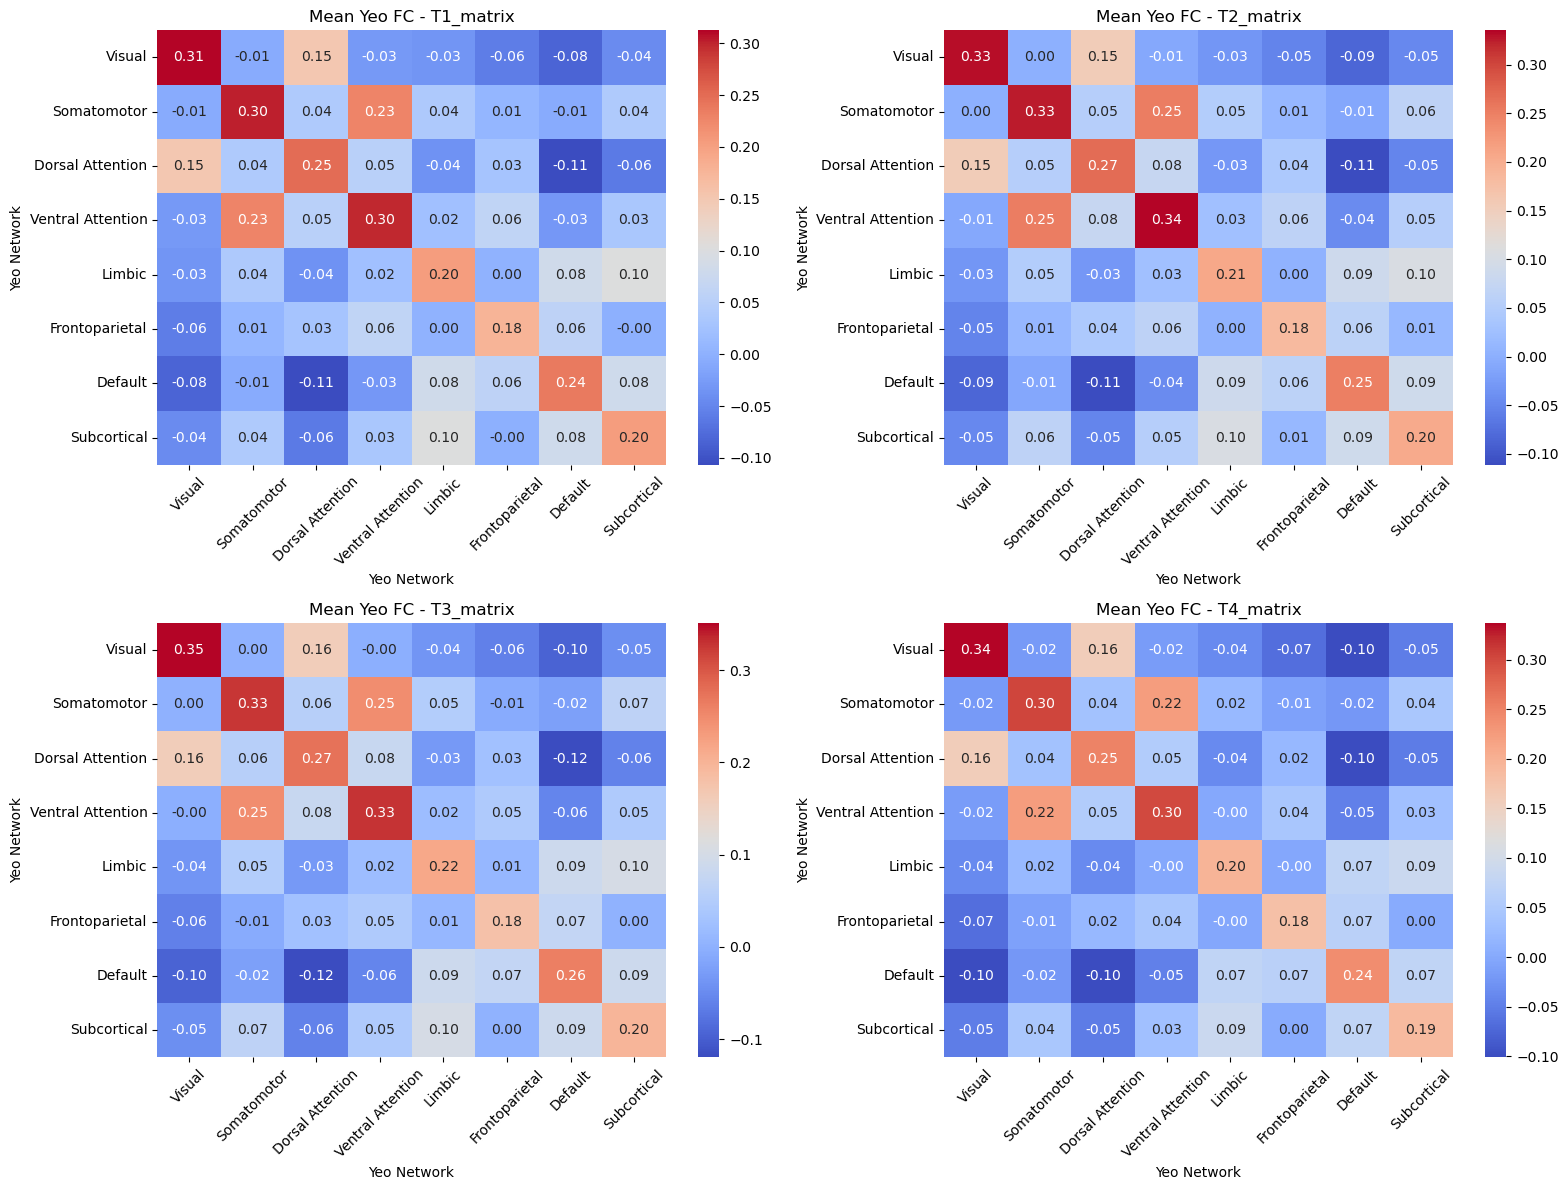

In [46]:
rois_sub = rois
rois_full = np.arange(0, 379)
t1_matrices, t1_subjects = functions.load_matrices(folder_path, rsfMRI_full_info, rois = rois_full, type='t1_only', subset=False, plot=True)

In [40]:
# WORKS !!
# GOOD !!!!
# But only for full matrix

yeo_path = "data/hcp_mmp10_yeo7_modes_indices.csv"
yeo = pd.read_csv(yeo_path, names=['Yeo_Network'])
yeo['Glasser_Index'] = range(1, 361)
new_rows = pd.DataFrame({
    'Glasser_Index': range(361, 380),      # 360 to 379 inclusive
    'Yeo_Network': 8               # constant value 8
})

region_to_yeo = pd.concat([yeo, new_rows], ignore_index=True)
region_to_yeo.Yeo_Network = region_to_yeo.Yeo_Network - 1
region_to_yeo.Glasser_Index = region_to_yeo.Glasser_Index - 1
region_to_yeo

network_to_indices = region_to_yeo.groupby('Yeo_Network')['Glasser_Index'].apply(list).to_dict()
#full_rois = np.arange(1, 379)
t1_matrix = t1_matrices.T1_matrix[1] # not none matrix to test
print("t1_matrix shape:", t1_matrix.shape)

print("Yeo network keys:", list(network_to_indices.keys()))
print("glasser keys:", list(network_to_indices.values()))

key_list = sorted(network_to_indices.keys())
key_to_idx = {k: i for i, k in enumerate(key_list)}
num_networks = region_to_yeo['Yeo_Network'].nunique()
fc_matrix = t1_matrix.to_numpy()
yeo_fc = np.zeros((num_networks, num_networks))

for i in key_list:
    for j in key_list:
        idx_i = network_to_indices[i]
        idx_j = network_to_indices[j]
        submatrix = fc_matrix[np.ix_(idx_i, idx_j)]
        yeo_fc[key_to_idx[i], key_to_idx[j]] = submatrix.mean()


yeo_label_map = {
    0: "Visual",
    1: "Somatomotor",
    2: "Dorsal Attention",
    3: "Ventral Attention",
    4: "Limbic",
    5: "Frontoparietal",
    6: "Default",
    7: "Subcortical"  # or "Other"
}
region_to_yeo['yeo_name'] = region_to_yeo['Yeo_Network'].map(yeo_label_map)
labels = [yeo_label_map[k] for k in key_list]

# heatmap of the Yeo networks
plt.figure(figsize=(10, 8))
sns.heatmap(yeo_fc, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)
plt.title("Functional Connectivity Matrix of Yeo Networks")
plt.xlabel("Yeo Network")
plt.ylabel("Yeo Network")
plt.xticks(ticks=np.arange(num_networks) + 0.5, labels=labels, rotation=45)
plt.yticks(ticks=np.arange(num_networks) + 0.5, labels=labels, rotation=0)
plt.tight_layout()
plt.show()

t1_matrix shape: (33, 33)
Yeo network keys: [0, 1, 2, 3, 4, 5, 6, 7]
glasser keys: [[0, 2, 3, 4, 5, 6, 12, 15, 17, 18, 19, 20, 21, 22, 118, 120, 125, 126, 141, 145, 151, 152, 153, 154, 155, 157, 158, 159, 162, 180, 181, 182, 183, 184, 185, 186, 192, 195, 196, 197, 198, 199, 200, 201, 202, 298, 300, 305, 306, 321, 331, 332, 333, 334, 335, 337, 338, 339, 342], [7, 8, 23, 35, 38, 39, 40, 50, 51, 52, 53, 54, 55, 99, 100, 101, 102, 103, 106, 123, 124, 138, 167, 172, 173, 174, 187, 188, 203, 215, 218, 219, 220, 230, 231, 232, 233, 234, 235, 278, 279, 280, 281, 282, 283, 286, 294, 303, 304, 347, 352, 353, 354], [1, 9, 10, 16, 41, 44, 45, 46, 47, 48, 49, 94, 95, 115, 116, 135, 136, 137, 140, 142, 156, 189, 190, 206, 221, 224, 225, 226, 227, 228, 229, 259, 274, 275, 295, 296, 315, 316, 317, 319, 320, 322, 325, 336], [24, 36, 37, 42, 43, 56, 58, 59, 77, 98, 104, 105, 107, 108, 112, 113, 114, 139, 146, 147, 166, 168, 177, 191, 204, 207, 216, 217, 222, 223, 236, 237, 238, 239, 257, 284, 285, 287, 

IndexError: index 118 is out of bounds for axis 0 with size 33

trying only on rois !!

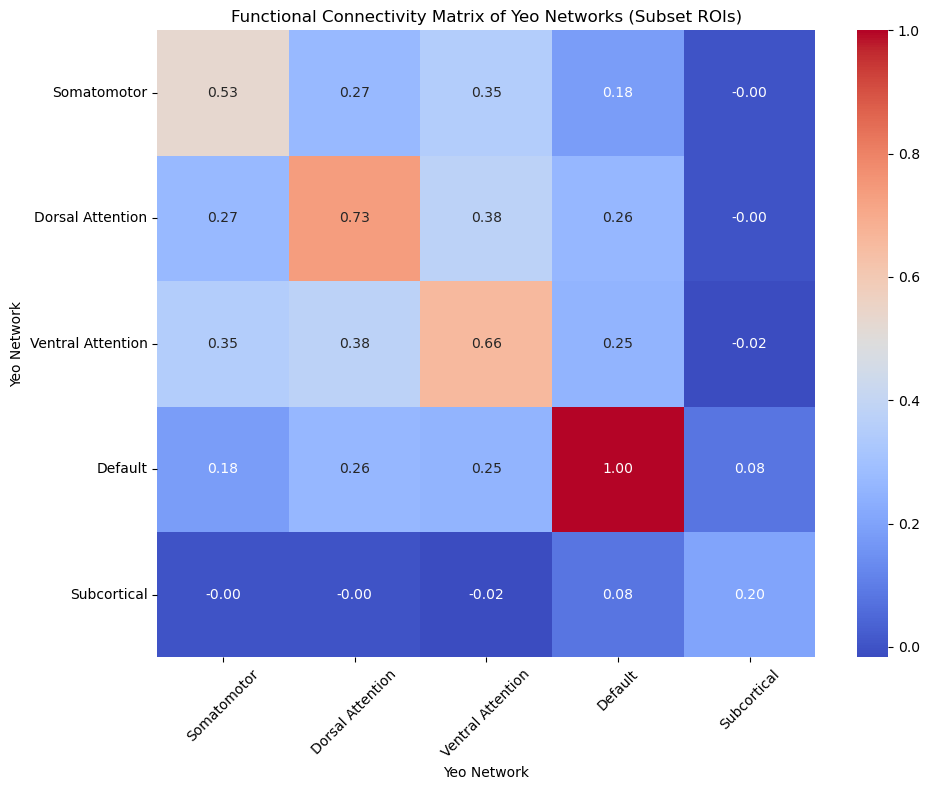

In [ ]:
# Load the matrix (choose a non-None subject)
t1_matrix = t1_matrices.T1_matrix[1]  # Replace '1' with your desired subject index
fc_matrix = t1_matrix.to_numpy()

# Load the Yeo network mapping
yeo_path = "data/hcp_mmp10_yeo7_modes_indices.csv"
yeo = pd.read_csv(yeo_path, names=['Yeo_Network'])
yeo['Glasser_Index'] = range(1, 361)  # 1-based indexing

# Add additional ROIs (361–379) mapped to Yeo network 8 (index 7 after shift)
new_rows = pd.DataFrame({
    'Glasser_Index': range(361, 380),  # 360 to 379 inclusive
    'Yeo_Network': 8
})

# Combine and shift to 0-based indexing
region_to_yeo = pd.concat([yeo, new_rows], ignore_index=True)
region_to_yeo['Yeo_Network'] = region_to_yeo['Yeo_Network'] - 1
region_to_yeo['Glasser_Index'] = region_to_yeo['Glasser_Index'] - 1

# Define your ROI subset (0-based indices)
rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 12, 54, 56,
        78, 96, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]  # Already 0-based in this context

# Filter the mapping to match the selected ROIs
region_to_yeo = region_to_yeo[region_to_yeo['Glasser_Index'].isin(rois)]

# Remap FC matrix to selected ROIs
fc_matrix = fc_matrix[rois, :][:, rois]

# Create Glasser → local FC matrix index map
glasser_to_local = {roi: idx for idx, roi in enumerate(rois)}

# Group Glasser indices by Yeo network
network_to_indices = region_to_yeo.groupby('Yeo_Network')['Glasser_Index'].apply(list).to_dict()

# Build network-to-index map
key_list = sorted(network_to_indices.keys())
key_to_idx = {k: i for i, k in enumerate(key_list)}
num_networks = len(key_list)
yeo_fc = np.zeros((num_networks, num_networks))

# Compute average FC per network pair
for i in key_list:
    for j in key_list:
        idx_i = [glasser_to_local[g] for g in network_to_indices[i]]
        idx_j = [glasser_to_local[g] for g in network_to_indices[j]]
        submatrix = fc_matrix[np.ix_(idx_i, idx_j)]
        yeo_fc[key_to_idx[i], key_to_idx[j]] = submatrix.mean()

# Optional: map Yeo network indices to names
yeo_label_map = {
    0: "Visual",
    1: "Somatomotor",
    2: "Dorsal Attention",
    3: "Ventral Attention",
    4: "Limbic",
    5: "Frontoparietal",
    6: "Default",
    7: "Subcortical"
}
region_to_yeo['yeo_name'] = region_to_yeo['Yeo_Network'].map(yeo_label_map)
labels = [yeo_label_map[k] for k in key_list]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(yeo_fc, cmap='coolwarm', annot=True, fmt=".2f", cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.title("Functional Connectivity Matrix of Yeo Networks (Subset ROIs)")
plt.xlabel("Yeo Network")
plt.ylabel("Yeo Network")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# NOTE: Intra-network FC includes diagonals

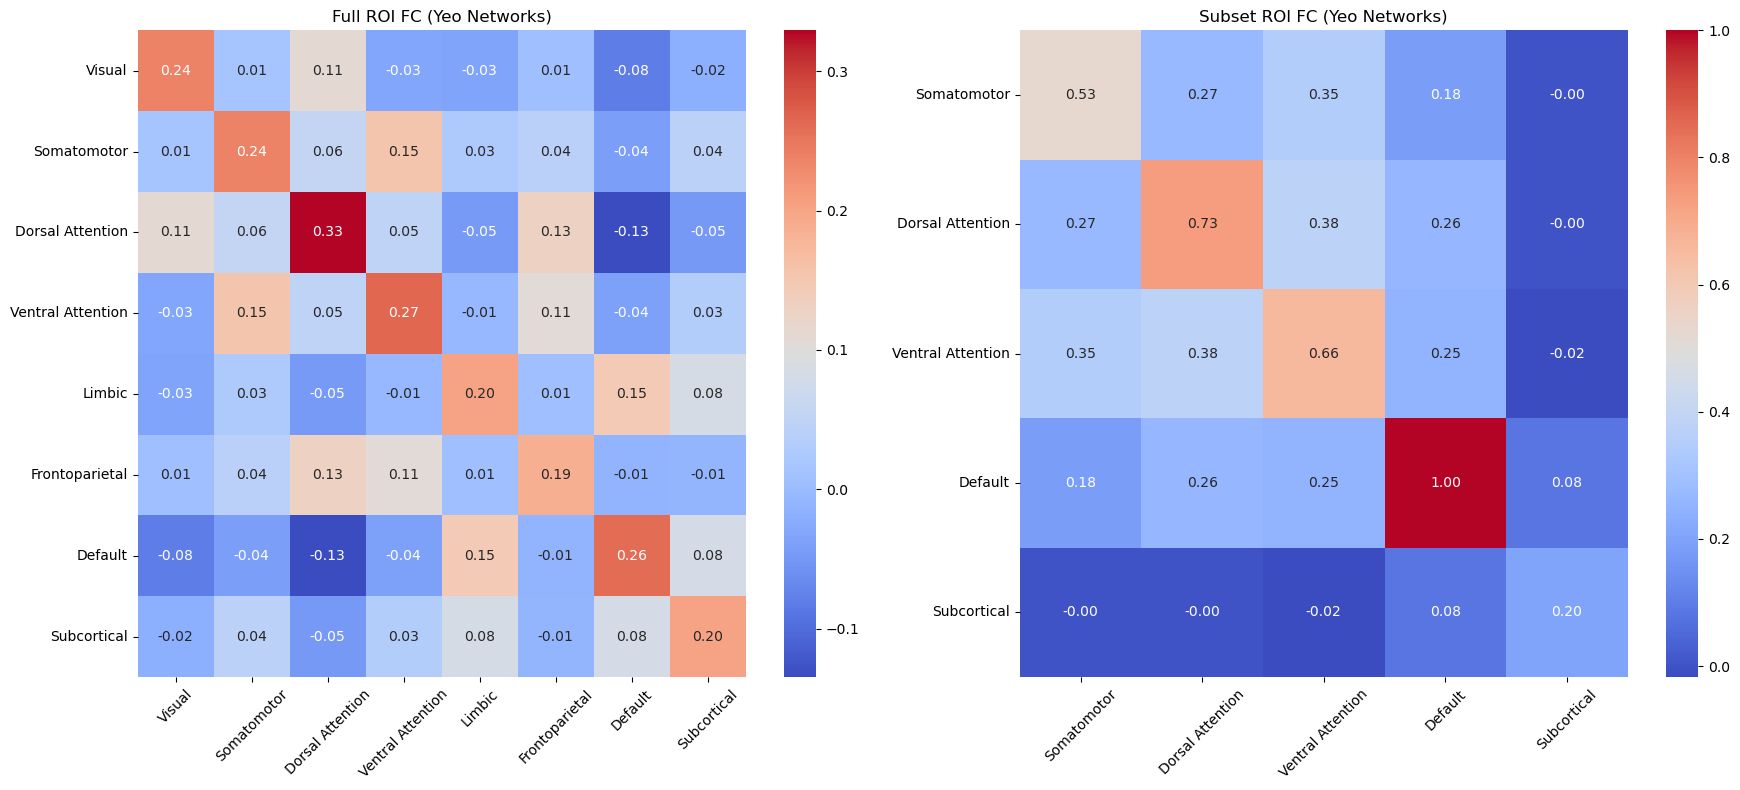

In [ ]:
# --- Load and prepare Yeo mapping ---
yeo_path = "data/hcp_mmp10_yeo7_modes_indices.csv"
yeo = pd.read_csv(yeo_path, names=['Yeo_Network'])
yeo['Glasser_Index'] = range(1, 361)
new_rows = pd.DataFrame({
    'Glasser_Index': range(361, 380),
    'Yeo_Network': 8
})
region_to_yeo = pd.concat([yeo, new_rows], ignore_index=True)
region_to_yeo['Yeo_Network'] = region_to_yeo['Yeo_Network'] - 1
region_to_yeo['Glasser_Index'] = region_to_yeo['Glasser_Index'] - 1

# Optional: Yeo network names
yeo_label_map = {
    0: "Visual", 1: "Somatomotor", 2: "Dorsal Attention", 3: "Ventral Attention",
    4: "Limbic", 5: "Frontoparietal", 6: "Default", 7: "Subcortical"
}
region_to_yeo['yeo_name'] = region_to_yeo['Yeo_Network'].map(yeo_label_map)

# --- Load FC matrix ---
t1_matrix = t1_matrices.T1_matrix[1]  # pick a valid subject
fc_matrix_full = t1_matrix.to_numpy()

# --- Compute full-ROI FC matrix ---
network_to_indices_full = region_to_yeo.groupby('Yeo_Network')['Glasser_Index'].apply(list).to_dict()
key_list_full = sorted(network_to_indices_full.keys())
key_to_idx_full = {k: i for i, k in enumerate(key_list_full)}
num_networks_full = len(key_list_full)
yeo_fc_full = np.zeros((num_networks_full, num_networks_full))

for i in key_list_full:
    for j in key_list_full:
        idx_i = network_to_indices_full[i]
        idx_j = network_to_indices_full[j]
        submatrix = fc_matrix_full[np.ix_(idx_i, idx_j)]
        yeo_fc_full[key_to_idx_full[i], key_to_idx_full[j]] = submatrix.mean()

# --- Compute subset FC matrix ---
subset_rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371,
               12, 54, 56, 78, 96, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53,
               188, 189, 231, 232, 233]
subset_rois = [roi - 1 for roi in subset_rois]
region_to_yeo_subset = region_to_yeo[region_to_yeo['Glasser_Index'].isin(subset_rois)]
fc_matrix_subset = fc_matrix_full[subset_rois, :][:, subset_rois]
glasser_to_local = {roi: idx for idx, roi in enumerate(subset_rois)}

network_to_indices_sub = region_to_yeo_subset.groupby('Yeo_Network')['Glasser_Index'].apply(list).to_dict()
key_list_sub = sorted(network_to_indices_sub.keys())
key_to_idx_sub = {k: i for i, k in enumerate(key_list_sub)}
num_networks_sub = len(key_list_sub)
yeo_fc_sub = np.zeros((num_networks_sub, num_networks_sub))

for i in key_list_sub:
    for j in key_list_sub:
        idx_i = [glasser_to_local[g] for g in network_to_indices_sub[i]]
        idx_j = [glasser_to_local[g] for g in network_to_indices_sub[j]]
        submatrix = fc_matrix_subset[np.ix_(idx_i, idx_j)]
        yeo_fc_sub[key_to_idx_sub[i], key_to_idx_sub[j]] = submatrix.mean()

labels_full = [yeo_label_map[k] for k in key_list_full]
labels_sub = [yeo_label_map[k] for k in key_list_sub]

# --- Plot side-by-side heatmaps ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(yeo_fc_full, cmap='coolwarm', annot=True, fmt=".2f",
            xticklabels=labels_full, yticklabels=labels_full, ax=axes[0])
axes[0].set_title("Full ROI FC (Yeo Networks)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

sns.heatmap(yeo_fc_sub, cmap='coolwarm', annot=True, fmt=".2f",
            xticklabels=labels_sub, yticklabels=labels_sub, ax=axes[1])
axes[1].set_title("Subset ROI FC (Yeo Networks)")
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()


In [38]:
import importlib
importlib.reload(functions)

<module 'functions' from '/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA4/Project Hummel/uphummel_MA4/functions.py'>

In [ ]:
region_to_yeo = functions.get_yeo_labels(yeo_path)
print(region_to_yeo)
#yeo_1, yeo_2 = functions.compute_and_plot_mean_yeo_matrices(all_matrices, region_to_yeo, rois)
all_matrices.T1_matrix[1].shape

     Yeo_Network  Glasser_Index
0              0              0
1              2              1
2              0              2
3              0              3
4              0              4
..           ...            ...
374            7            374
375            7            375
376            7            376
377            7            377
378            7            378

[379 rows x 2 columns]


(33, 33)

In [ ]:
t1_matrix = t1_matrices.T1_matrix[1] # not none matrix to test
t2_matrix = all_matrices.T1_matrix[1] # not none matrix to test
t1_matrix.shape, t2_matrix.shape

((379, 379), (33, 33))

In [32]:
def get_mean_yeo_matrices(matrices, region_to_yeo, rois, subset=False):
    import numpy as np

    matrix_columns = ['T1_matrix', 'T2_matrix', 'T3_matrix', 'T4_matrix']
    mean_yeo_dict = {}
    labels = None  # initialize labels outside loop

    for idx, timepoint in enumerate(matrix_columns):
        valid_matrices = matrices[timepoint].dropna()
        yeo_matrices = []

        for mat in valid_matrices:
            fc_matrix = mat.to_numpy()

            # Subset if needed
            if subset:
                subset_map = region_to_yeo[region_to_yeo['Glasser_Index'].isin(rois)].copy()
            else:
                subset_map = region_to_yeo.copy()

            # Remap Glasser indices to matrix indices
            index_map = {roi: i for i, roi in enumerate(rois)}
            subset_map = subset_map[subset_map['Glasser_Index'].isin(index_map)]

            # Group by Yeo network
            network_to_indices = subset_map.groupby('Yeo_Network')['Glasser_Index'].apply(list).to_dict()
            key_list = sorted(network_to_indices.keys())
            key_to_idx = {k: i for i, k in enumerate(key_list)}
            num_networks = len(key_list)

            yeo_fc = np.zeros((num_networks, num_networks))

            for i in key_list:
                for j in key_list:
                    idx_i = [index_map[g] for g in network_to_indices[i]]
                    idx_j = [index_map[g] for g in network_to_indices[j]]
                    submatrix = fc_matrix[np.ix_(idx_i, idx_j)]
                    yeo_fc[key_to_idx[i], key_to_idx[j]] = submatrix.mean()

            yeo_matrices.append(yeo_fc)

        if len(yeo_matrices) == 0:
            continue

        # Average across subjects
        stacked = np.stack(yeo_matrices)
        mean_yeo = np.nanmean(stacked, axis=0)
        mean_yeo_dict[timepoint] = mean_yeo

        if labels is None:
            yeo_label_map = region_to_yeo.set_index('Yeo_Network')['yeo_name'].to_dict()
            labels = [yeo_label_map[k] if k in yeo_label_map else str(k) for k in key_list]

    return mean_yeo_dict, labels

def plot_mean_yeo_matrices(mean_yeo_dict, labels):
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, (timepoint, matrix) in enumerate(mean_yeo_dict.items()):
        sns.heatmap(matrix, ax=axes[idx], cmap='coolwarm', annot=True, fmt=".2f",
                    xticklabels=labels, yticklabels=labels)
        axes[idx].set_title(f"Mean Yeo FC - {timepoint}")
        axes[idx].set_xlabel("Yeo Network")
        axes[idx].set_ylabel("Yeo Network")
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


IndexError: index 118 is out of bounds for axis 0 with size 33

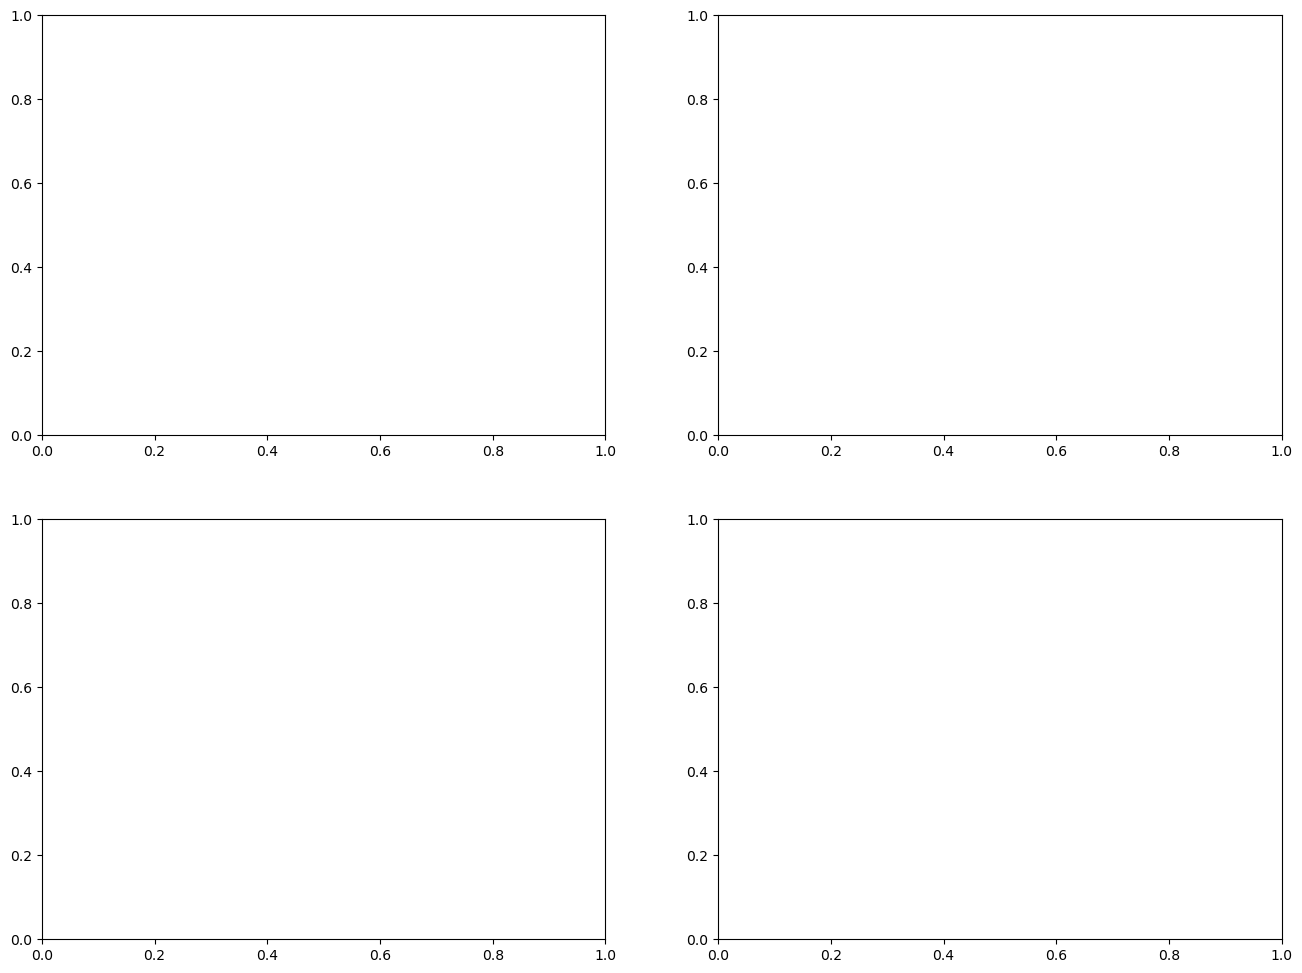

In [43]:
def plot_mean_yeo_matrices(matrices, region_to_yeo, rois, subset=False):
    """
    Plot the mean Yeo FC matrices in a 2x2 grid for T1 to T4 timepoints.

    Args:
        matrices (pd.DataFrame): DataFrame with subject FC matrices (T1_matrix to T4_matrix).
        region_to_yeo (pd.DataFrame): Mapping of Glasser_Index to Yeo_Network.
        rois (list or None): Optional list of ROI indices to restrict analysis to.
        label_map (dict or None): Optional Yeo_Network label-to-name mapping.
    """

    matrix_columns = ['T1_matrix', 'T2_matrix', 'T3_matrix', 'T4_matrix']
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, timepoint in enumerate(matrix_columns):
        valid_matrices = matrices[timepoint].dropna()

        if len(valid_matrices) == 0:
            axes[idx].axis('off')
            axes[idx].set_title(f'No data for {timepoint}')
            continue

        # Compute FC matrices at the Yeo network level for all subjects
        yeo_matrices = []

        for mat in valid_matrices:
            fc_matrix = mat.to_numpy()

            # Optional: subset the matrix
            if subset == True:
                #fc_matrix = fc_matrix[rois, :][:, rois]
                subset_map = region_to_yeo[region_to_yeo['Glasser_Index'].isin(rois)].copy()
            else:
                subset_map = region_to_yeo.copy()

            # Remap Glasser indices to FC matrix local indices
            index_map = {roi: i for i, roi in enumerate(rois)}
            subset_map = subset_map[subset_map['Glasser_Index'].isin(index_map)]

            # Group by Yeo network
            network_to_indices = subset_map.groupby('Yeo_Network')['Glasser_Index'].apply(list).to_dict()
            key_list = sorted(network_to_indices.keys())
            key_to_idx = {k: i for i, k in enumerate(key_list)}
            num_networks = len(key_list)

            yeo_fc = np.zeros((num_networks, num_networks))

            for i in key_list:
                for j in key_list:
                    idx_i = [index_map[g] for g in network_to_indices[i]]
                    idx_j = [index_map[g] for g in network_to_indices[j]]
                    submatrix = fc_matrix[np.ix_(idx_i, idx_j)]
                    yeo_fc[key_to_idx[i], key_to_idx[j]] = submatrix.mean()

            yeo_matrices.append(yeo_fc)

        # Average across subjects
        stacked = np.stack(yeo_matrices)
        mean_yeo = np.nanmean(stacked, axis=0)

        # Label axes
        # Use the 'yeo_name' column from region_to_yeo for labels
        yeo_label_map = region_to_yeo.set_index('Yeo_Network')['yeo_name'].to_dict()
        labels = [yeo_label_map[k] if k in yeo_label_map else str(k) for k in key_list]

        sns.heatmap(mean_yeo, ax=axes[idx], cmap='coolwarm', annot=True, fmt=".2f",
                    xticklabels=labels, yticklabels=labels)
        axes[idx].set_title(f"Mean Yeo FC - {timepoint}")
        axes[idx].set_xlabel("Yeo Network")
        axes[idx].set_ylabel("Yeo Network")
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

yeo_path = "data/hcp_mmp10_yeo7_modes_indices.csv"
rois_full = np.arange(0, 379)
region_to_yeo = functions.glasser_mapped_to_yeo(yeo_path)
plot_mean_yeo_matrices(all_matrices, region_to_yeo, rois_full, subset=False)

In [36]:
yeo_path = "data/hcp_mmp10_yeo7_modes_indices.csv"
rois_full = np.arange(0, 379)
region_to_yeo = functions.glasser_mapped_to_yeo(yeo_path)
mean_yeo, labels = get_mean_yeo_matrices(t1_matrix, region_to_yeo, rois_full, subset=False)
plot_mean_yeo_matrices(mean_yeo, labels)

TypeError: glasser_mapped_to_yeo() takes 0 positional arguments but 1 was given